In [146]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import xapian
import nltk
import os
import io
from zipfile import ZipFile
import shutil
import csv
import re
import pandas as pd
import numpy as np
import json
import spacy 
import en_core_web_lg
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
from nltk.chunk import conlltags2tree, tree2conlltags
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
vectorizer = DictVectorizer()
nlp_large = en_core_web_lg.load() 

import en_vectors_web_lg
nlpvec = en_vectors_web_lg.load() 


In [366]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from joblib import dump, load

/Users/indah/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:

dbpath = "index_V6_nostop"

print("### GET TRAINING DATA ###")

train_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "train.json")
with open(train_path) as json_file:  
    train = json.load(json_file)

rowid = list(train.keys())
claim = []
label = []
evidence = []
for idx in rowid:
    claim.append(train[idx]['claim'])
    label.append(train[idx]['label'])
    evidence.append(train[idx]['evidence'])
    
len_claim = len(claim)    

print("training set:",len_claim)

print("### CONNECT TO INDEX ###")

def getstopper():
    stopper = xapian.SimpleStopper()
    for s in stopwords.words('english'):
        stopper.add(s)
    return stopper

def get_doc_id(match):
    for term in match.document.termlist():
        term = term.term.decode("utf-8") 
        m = re.match("Q(.*)", term)
        if m:
            return m[1]
    return None

# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(dbpath)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
queryparser.set_stemmer(xapian.Stem("en"))
queryparser.set_stemming_strategy(queryparser.STEM_SOME)
queryparser.set_stopper(getstopper())
queryparser.add_prefix('keywords', 'K')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)

def get_match(query,pagesize):
    query = queryparser.parse_query(query)
    enquire.set_query(query)
    matches = enquire.get_mset(0, pagesize)

    query_results = []
    #doc_title = []
    for match in matches:
        result = dict(
            found_doc = get_doc_id(match),
            rank = match.rank + 1, 
            percent = match.percent,
            weight = match.weight,
            docid = match.docid,
            text = match.document.get_data()
        )
        query_results.append(result)
        #doc_title.append(get_doc_id(match))
    return query_results #, doc_title

print("### NORMALIZATION ###")
    
def replace_punctuation(sentence):
    text = re.sub(r"(-LRB-|-LSB-|-RSB-|-RRB-|-COLON-|-lrb-|-lsb-|-rsb-|-rrb-|-colon-|``|'')*", "", sentence)
    text = re.sub(r"[`']+", " ", text)
    text = re.sub(r"[.,:;]*", "", text)
    text = text.replace("_"," ")
    text = text.replace("\\n","")
    text = text.strip()
    return text

def get_entity(document):
    doc = nlp_large(document)
    combine_entity = ''
    for entity in doc.ents:
        combine_entity = combine_entity + ' ' + str(entity)
    return combine_entity.strip()

def remove_stopwords(wordlist):
    filtered = [w for w in wordlist if w not in stopwords.words('english')]
    return filtered

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma  

def normalize_counter(document):  
    entities = get_entity(document)
    combine = document + ' ' + entities
    filtered = nltk.word_tokenize(combine)
    #filtered = remove_stopwords(filtered)
    for i in range(len(filtered)):
         filtered[i] = lemmatize(filtered[i].lower())
    word_counter = Counter(filtered)
    return word_counter 

def get_entity_list(document):
    doc = nlp_large(document)
    combine_entity = set()
    for entity in doc.ents:
        combine_entity.add(str(entity).lower().strip())
    return list(combine_entity)

def capital(text):
    result = re.findall(r"[A-Z][\S]+", text)
    result = [w.lower() for w in result]
    return result

def entity_capital(text):
    text = replace_punctuation(text)
    entities = get_entity_list(text)
    capitals = capital(text)
    entities.extend(capitals)
    entities = set(entities)
    entities = remove_stopwords(entities)
    return entities

def document_entities(result):
    docid = result['found_doc']
    pattern = re.compile(r"("+docid+"\s\d+\s)")
    doc = result['text'].decode("utf-8")
    doc = replace_punctuation(doc)
    doc = re.sub(pattern,"",doc)
    doc_entities = entity_capital(doc)
    return doc_entities

def intersection(list1, list2): 
    list3 = [value for value in list1 if value in list2] 
    return len(list3) 

def similarity_list(claim, wiki):     
    claim_wiki = [' '.join(claim).strip(),' '.join(wiki).strip()]
    vectorizer = CountVectorizer(claim_wiki)
    try:
        vectorizer.fit(claim_wiki)
        vectors = [vector for vector in vectorizer.transform(claim_wiki).toarray()]
        similarity = cosine_similarity(vectors)[1][0]
    except:
        similarity = 0
    return similarity


In [170]:
def get_doc_match(doc_list, pagesize):
    #Search within selected document list
    #claim_text ="Nacional"
    #doc_list = ["C.D._Nacional"]#"Robert_J.O'Neill-LRB-U.S._Navy_SEAL-RRB-"]#'1994–95_Venezuelan_Primera_División_season','Lara_Croft-COLON-_Tomb_Raider']
    qp = xapian.QueryParser()
    
    doc_queries = ['Q{}'.format(rated) for rated in doc_list] #this could to ensure the exact full id text is taken
    doc_query = xapian.Query(xapian.Query.OP_OR, doc_queries)
    #print(doc_query)
    # setup the enquire object to perform the query
    #enq = xapian.Enquire(db)
    # set the weighting model for ranking
    #enq.set_weighting_scheme(xapian.BM25Weight())
    #enq.set_weighting_scheme(xapian.TfIdfWeight())
    enquire.set_query(doc_query)

    # iterate through the matched set and display the stored json dup
    #print("Doc Level Results:\n")
    #enquire.set_query(query)
    matches = enquire.get_mset(0, pagesize)
    
    query_results = []
    doc_title = []
    for match in matches:
        result = dict(
            found_doc = get_doc_id(match),
            rank = match.rank + 1, 
            percent = match.percent,
            weight = match.weight,
            docid = match.docid,
            text = match.document.get_data()
        )
        query_results.append(result)
    return query_results



In [95]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/decomposable-attention-elmo-2018.02.19.tar.gz")


/Users/indah/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight


In [158]:
def textual_entailment(claim,wiki):
    te = predictor.predict(claim,wiki)
    if te['label_probs'][0] > 0.5:
        print("SUPPORT:", te['label_probs'][0])
        return 'SUPPORTS'
    elif te['label_probs'][1] > 0.5:
        print('REFUTES:', te['label_probs'][1])
        return 'REFUTES'
    else:
        print('NOT ENOUGH INFO:', te['label_probs'][2])
        return 'NOT ENOUGH INFO'

In [148]:
def replace_punctuation_old(sentence):
    #text = sentence.decode("utf-8").lower()
    text = re.sub(r"(-LRB-|-LSB-|-RSB-|-RRB-|-COLON-|-lrb-|-lsb-|-rsb-|-rrb-|-colon-)*", "", sentence)
    text = re.sub(r"[.,:;`']*", "", text)
    text = text.replace("\\n","")
    return text
def replace_punctuation(sentence):
    text = re.sub(r"(-LRB-|-LSB-|-RSB-|-RRB-|-COLON-|-lrb-|-lsb-|-rsb-|-rrb-|-colon-|``|'')*", "", sentence)
    text = re.sub(r"[`']+", " ", text)
    text = re.sub(r"[.,:;]*", "", text)
    text = text.replace("_"," ")
    text = text.replace("\\n","")
    text = text.strip()
    return text

def get_entity(document):
    doc = nlp_large(document)
    combine_entity = ''
    for entity in doc.ents:
        combine_entity = combine_entity + ' ' + str(entity)
    return combine_entity.strip()

def get_entity_list(document):
    doc = nlp_large(document)
    combine_entity = set()
    entity = [str(ent.text).lower().strip() for ent in doc.ents]
    combine_entity = set(entity)
    return list(combine_entity)

def remove_stopwords(wordlist):
    filtered = [w for w in wordlist if w not in stopwords.words('english')]
    return filtered

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma  

def normalize_counter(document):  
    entities = get_entity(document)
    combine = document + ' ' + entities
    filtered = nltk.word_tokenize(combine)
    #tokenize and remove stop words
    filtered = remove_stopwords(filtered)
    for i in range(len(filtered)):
         filtered[i] = lemmatize(filtered[i].lower())
    word_counter = Counter(filtered)
    return word_counter 

def get_match2(query,pagesize):
    query = queryparser.parse_query(query)
    enquire.set_query(query)
    matches = enquire.get_mset(0, pagesize)
    
    query_results = []
    doc_title = []
    for match in matches:
        result = dict(
            found_doc = get_doc_id(match),
            rank = match.rank + 1, 
            percent = match.percent,
            weight = match.weight,
            docid = match.docid,
            text = match.document.get_data()
        )
        query_results.append(result)
        doc_title.append(get_doc_id(match))
    return query_results , doc_title

def similarity(claim, wiki):     
    claim_wiki = [claim,wiki]
    vectorizer = CountVectorizer(claim_wiki)
    try:
        vectorizer.fit(claim_wiki)
        vectors = [vector for vector in vectorizer.transform(claim_wiki).toarray()]
        similarity = cosine_similarity(vectors)[1][0]
    except:
        similarity = 0
    return similarity


def get_text_embedding(text):
    return nlpvec(text).vector

def get_te_scores(claim, text):
    prediction = predictor.predict(
       hypothesis = claim,
       premise = text
    )
        
    ContradictionScore = prediction['label_probs'][0]
    EntailmentScore = prediction['label_probs'][1]
    NeutralScore = prediction['label_probs'][2]
    return ContradictionScore, EntailmentScore, NeutralScore
    
def get_sent_similarity(claim, text):
    clm = nlpvec(claim)
    sent = nlpvec(text)
    return clm.similarity(sent)


In [298]:
def get_nouns(document):
    doc = nlp_large(document)
    combine_noun = set()
    noun = [str(noun).lower().replace(" ","_").strip() for noun in doc.noun_chunks]
    combine_noun = set(noun)
    return ' '.join(combine_noun)

def get_entity_similarity(claim, text):
    clm = get_entity(claim)
    sent = get_entity(text)
    return get_sent_similarity(clm,sent)

def get_noun_similarity(claim, text):
    clm = get_nouns(claim)
    sent = get_nouns(text)
    return get_sent_similarity(clm,sent)

In [ ]:
%%time
incomplete_claim2 = set()
document_not_found2 = set()
# features = defaultdict(Counter)
# claim_embed = dict()
# evidences_embed = dict()
# conta_score = dict()
# ent_score = dict()
# nut_core  = dict()
# similarity_score = dict()
entity_similarity_score = dict()
noun_similarity_score = dict()

# features_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "features1.json")
# claim_embed_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "claim_embed.json")
# evidences_embed_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "evidences_embed.json")
# conta_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "conta_score.json")
# ent_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "ent_score.json")
# nut_core_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "nut_core.json")
# similarity_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "similarity_score.json")
entity_similarity_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "entity_similarity_score.json")
noun_similarity_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "noun_similarity_score.json")


for i in range(len(tclaim)):
    norm_claim = replace_punctuation(tclaim[i]).lower()
    norm_text = ''
    for j in range(len(tevidence[i])):
        evidence_id = tevidence[i][j][0]#.lower()
        #fetch from xapian the document matching the evidence name
        #print("get_doc_match([evidence_id],1)",[evidence_id])
        results = get_doc_match([evidence_id],1)
        evidence_id = evidence_id.lower()
        #print(evidence_id)
        #print("---------")
        #print(i, evidence[i], results[0]['found_doc'].lower())
        if results != []:
            #make sure the document found matches the evidence we picked from training set
            if evidence_id == results[0]['found_doc'].lower():
                #get sentence Id from traning set
                evidence_sent = str(tevidence[i][j][1])
                sentence_id = evidence_id + ' ' + evidence_sent
                #take sentence text from xapian for selected doc
                text = results[0]['text'].decode("utf-8").lower()
                #print("full text",text)
                index = text.find(sentence_id)
                if index != -1:
                    lenid = len(sentence_id)
                    if text[index+lenid:].find(evidence_id) != -1:
                        textsplit = replace_punctuation(text[index+lenid:].split(evidence_id, maxsplit=1)[0])  
                    else:
                        textsplit = replace_punctuation(text[index+lenid:])
                    norm_text += textsplit + ' '
                    #print("???>>>textsplit",textsplit)
                    combine = norm_claim + ' ' + textsplit
                    counter_combine = normalize_counter(combine)

                    features[i].update(counter_combine)

                else:
                    document_not_found2.add(evidence_id)
                    incomplete_claim2.add(i)      
            else:
                document_not_found2.add(evidence_id)
                incomplete_claim2.add(i)
        else:
            document_not_found2.add(evidence_id)
            incomplete_claim2.add(i)


    #TODO here extract featrues at claim level
#         print("||||norm_claim",norm_claim)
#         print("||||norm_text",norm_text,"\n\n")
#     claim_embed[i] = get_text_embedding(norm_claim)
#     evidences_embed[i] = get_text_embedding(norm_text)
#     cont_score, e_score, n_core = get_te_scores(norm_claim, norm_text)
#     conta_score[i] = cont_score
#     ent_score[i] = e_score
#     nut_core[i] = n_core
#     sim = get_sent_similarity(norm_claim, norm_text)
#     similarity_score[i] = sim
    
    entity_similarity_score[i] = get_entity_similarity(norm_claim, norm_text)
    noun_similarity_score[i] = get_noun_similarity(norm_claim, norm_text)        
    print(i, entity_similarity_score[i], noun_similarity_score[i])
        
#         print("||||similarity_score",similarity_score[i])
#         print("||||NLPSCORE",cont_score, e_score, n_core)
#         print("|||Label",tlabel[i])
#         print("|||evidence",tevidence[i])
#         print("||||||||||||||||||||||||||||||||||")

with open(features_path, 'w') as outfile:
    json.dump(features, outfile)
with open(claim_embed_path, 'w') as outfile:
    json.dump(claim_embed, outfile)
with open(conta_score_path, 'w') as outfile:
    json.dump(conta_score, outfile)
with open(evidences_embed_path, 'w') as outfile:
    json.dump(evidences_embed, outfile)
with open(ent_score_path, 'w') as outfile:
    json.dump(ent_score, outfile)
with open(nut_core_path, 'w') as outfile:
    json.dump(nut_core, outfile)
with open(similarity_score_path, 'w') as outfile:
    json.dump(similarity_score, outfile)

with open(entity_similarity_path, 'w') as outfile:
    json.dump(entity_similarity_score, outfile)
with open(noun_similarity_path, 'w') as outfile:
    json.dump(noun_similarity_score, outfile)
    
# doc_not_found = {}
# for i in range(len_doc_not_found):
#     doc_not_found[i] = document_not_found[i]

# with open('doc_not_found.json', 'w') as f:
#     json.dump(doc_not_found, f, indent = 4)

<h2> Load All Features </h2>

In [305]:
print("### GET TRAINING FEATURE LIST ###")
      
      
feature_list_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "training_features/label_features.json")
with open(feature_list_path) as json_file:  
    feature_list_dict = json.load(json_file)
 

### GET TRAINING FEATURE LIST ###


In [306]:
len(feature_list_dict)

145449

In [312]:
trainids = list(feature_list_dict.keys())

In [358]:
claim = []
claim_embed = []
entity_similarity_score = []
evidence = []
evidences_embed = []
features = []
label = []
noun_similarity_score = []
rowidx =[]
similarity_score = []
document_not_found = []
incomplete_claim = []

for i in range(len(trainids)):
    if feature_list_dict[trainids[i]]['document_not_found'] == []:
        claim.append(feature_list_dict[trainids[i]]['claim'])
        claim_embed.append(feature_list_dict[trainids[i]]['claim_embed'])
        entity_similarity_score.append(feature_list_dict[trainids[i]]['entity_similarity_score'])
        evidence.append(feature_list_dict[trainids[i]]['evidence'])    
        evidences_embed.append(feature_list_dict[trainids[i]]['evidences_embed'])
        features.append(feature_list_dict[trainids[i]]['features'])
        label.append(feature_list_dict[trainids[i]]['label'])  
        noun_similarity_score.append(feature_list_dict[trainids[i]]['noun_similarity_score'])
        rowidx.append(feature_list_dict[trainids[i]]['rowidx'])
        similarity_score.append(feature_list_dict[trainids[i]]['similarity_score'])   
        document_not_found.append(feature_list_dict[trainids[i]]['document_not_found'])
        incomplete_claim.append(feature_list_dict[trainids[i]]['incomplete_claim'])

In [359]:
len(claim)

144227

In [360]:
claim_embed_array = np.array(claim_embed)
evidences_embed_array = np.array(evidences_embed)
entity_similarity_score_array = np.array(entity_similarity_score)
entity_similarity_score_array.resize((len(entity_similarity_score_array), 1))
noun_similarity_score_array = np.array(noun_similarity_score)
noun_similarity_score_array.resize((len(noun_similarity_score_array), 1))
similarity_score_array = np.array(similarity_score)
similarity_score_array.resize((len(similarity_score_array), 1))
feature_combine = np.concatenate((claim_embed_array,evidences_embed_array), axis=1)
feature_combine = np.concatenate((feature_combine,entity_similarity_score_array), axis=1)
feature_combine = np.concatenate((feature_combine,noun_similarity_score_array), axis=1)
feature_combine = np.concatenate((feature_combine,similarity_score_array), axis=1)


In [362]:
Counter(label)

Counter({'SUPPORTS': 79145, 'REFUTES': 29443, 'NOT ENOUGH INFO': 35639})

In [363]:
print("### RANDOM LIST ###")
          
    
import random

training_set = feature_combine[:140000]
training_label = label[:140000]
heldout_set = feature_combine[140000:]
heldout_label = label[140000:]


### RANDOM LIST ###


In [370]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [371]:
oversampling = RandomOverSampler(random_state=0)
X_oversampling, y_oversampling = oversampling.fit_resample(training_set, training_label)


In [372]:
undersampling = RandomUnderSampler(random_state=0)
X_undersampling, y_undersampling = undersampling.fit_resample(training_set, training_label)


In [373]:
print("y_oversampling:",Counter(y_oversampling))
print("y_undersampling:",Counter(y_undersampling))

y_oversampling: Counter({'SUPPORTS': 76835, 'REFUTES': 76835, 'NOT ENOUGH INFO': 76835})
y_undersampling: Counter({'NOT ENOUGH INFO': 28553, 'REFUTES': 28553, 'SUPPORTS': 28553})


In [364]:
Counter(training_label)

Counter({'SUPPORTS': 76835, 'REFUTES': 28553, 'NOT ENOUGH INFO': 34612})

In [374]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf.fit(X_undersampling, y_undersampling) 

predictions = clf.predict(heldout_set)

print(accuracy_score(heldout_label,predictions))
results = classification_report(heldout_label,predictions,  output_dict=True)

print(results)

### MLP Classifier 2 hidden layers 10 nodes & 5 nodes ###
0.7617695765318192
{'NOT ENOUGH INFO': {'precision': 0.9273584905660377, 'recall': 0.9571567672833495, 'f1-score': 0.9420220412074749, 'support': 1027}, 'REFUTES': {'precision': 0.48524844720496896, 'recall': 0.702247191011236, 'f1-score': 0.573921028466483, 'support': 890}, 'SUPPORTS': {'precision': 0.8579031399680681, 'recall': 0.6978354978354978, 'f1-score': 0.7696347576987348, 'support': 2310}, 'accuracy': 0.7617695765318192, 'macro avg': {'precision': 0.7568366925796916, 'recall': 0.7857464853766944, 'f1-score': 0.7618592757908975, 'support': 4227}, 'weighted avg': {'precision': 0.7963152451265627, 'recall': 0.7617695765318192, 'f1-score': 0.7703105374826884, 'support': 4227}}


In [377]:
dump(clf, 'MLPClassifier_300_undersampling.joblib') 

['MLPClassifier_300_undersampling.joblib']

In [378]:
MLPClassifier_300_undersampling = load('MLPClassifier_300_undersampling.joblib') 

In [407]:
print("### MLP Classifier 1 hidden layers 300 nodes oversampling ###")

clf_os = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_os.fit(X_oversampling, y_oversampling) 

predictions_os = clf_os.predict(heldout_set)

print(accuracy_score(heldout_label,predictions_os))
results_os = classification_report(heldout_label,predictions_os,  output_dict=True)

print(results_os)

### MLP Classifier 1 hidden layers 300 nodes oversampling ###
0.7892122072391767
{'NOT ENOUGH INFO': {'precision': 0.9403409090909091, 'recall': 0.9668938656280428, 'f1-score': 0.9534325492078731, 'support': 1027}, 'REFUTES': {'precision': 0.5259067357512953, 'recall': 0.6842696629213483, 'f1-score': 0.5947265625, 'support': 890}, 'SUPPORTS': {'precision': 0.8614008941877794, 'recall': 0.7506493506493507, 'f1-score': 0.8022206800832754, 'support': 2310}, 'accuracy': 0.7892122072391767, 'macro avg': {'precision': 0.7758828463433279, 'recall': 0.8006042930662473, 'f1-score': 0.7834599305970494, 'support': 4227}, 'weighted avg': {'precision': 0.8099416072933018, 'recall': 0.7892122072391767, 'f1-score': 0.7952712655911643, 'support': 4227}}


In [408]:
dump(clf_os, 'MLPClassifier_300_oversampling.joblib') 

['MLPClassifier_300_oversampling.joblib']

In [409]:
MLPClassifier_300_oversampling = load('MLPClassifier_300_oversampling.joblib') 

In [412]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ap = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_ap.fit(training_set, training_label) 

predictions_ap = clf_ap.predict(heldout_set)

print(accuracy_score(heldout_label,predictions_ap))
results_ap = classification_report(heldout_label,predictions_ap,  output_dict=True)

print(results_ap)

### MLP Classifier 1 hidden layers 300 nodes actual proportion ###
0.827064111663118
{'NOT ENOUGH INFO': {'precision': 0.95274831243973, 'recall': 0.9620253164556962, 'f1-score': 0.9573643410852714, 'support': 1027}, 'REFUTES': {'precision': 0.7091932457786116, 'recall': 0.4247191011235955, 'f1-score': 0.5312719606465215, 'support': 890}, 'SUPPORTS': {'precision': 0.8016560030109146, 'recall': 0.922077922077922, 'f1-score': 0.8576605596939803, 'support': 2310}, 'accuracy': 0.827064111663118, 'macro avg': {'precision': 0.8211991870764187, 'recall': 0.7696074465524045, 'f1-score': 0.7820989538085911, 'support': 4227}, 'weighted avg': {'precision': 0.8188975331378707, 'recall': 0.827064111663118, 'f1-score': 0.8131632638190377, 'support': 4227}}


In [437]:
claim_evidence_dotproduct = []
for i in range(len(claim_embed_array)):
    dotproduct = claim_embed_array[i].dot(evidences_embed_array[i])
    claim_evidence_dotproduct.append(dotproduct)

In [438]:
claim_evidence_dotproduct_array = np.array(claim_evidence_dotproduct)
claim_evidence_dotproduct_array.resize((len(claim_evidence_dotproduct_array), 1))

In [439]:
feature_combine_2 = np.concatenate((claim_evidence_dotproduct_array,evidences_embed_array), axis=1)
feature_combine_2 = np.concatenate((feature_combine_2,entity_similarity_score_array), axis=1)
feature_combine_2 = np.concatenate((feature_combine_2,noun_similarity_score_array), axis=1)
feature_combine_2 = np.concatenate((feature_combine_2,similarity_score_array), axis=1)


In [441]:
print("### RANDOM LIST ###")

combined = list(zip(feature_combine_2, label))
random.shuffle(combined)
feature_combine_2, label = zip(*combined)

training_set2 = feature_combine_2[:140000]
training_label2 = label[:140000]
heldout_set2 = feature_combine_2[140000:]
heldout_label2 = label[140000:]


### RANDOM LIST ###


In [443]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ap2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_ap2.fit(training_set2, training_label2) 

predictions_ap2 = clf_ap2.predict(heldout_set2)

print(accuracy_score(heldout_label2,predictions_ap2))
results_ap2 = classification_report(heldout_label2,predictions_ap2,  output_dict=True)

print(results_ap2)

### MLP Classifier 1 hidden layers 300 nodes actual proportion ###
0.7480482611781405
{'NOT ENOUGH INFO': {'precision': 0.872791519434629, 'recall': 0.8973660308810173, 'f1-score': 0.8849081952530229, 'support': 1101}, 'REFUTES': {'precision': 0.2, 'recall': 0.001183431952662722, 'f1-score': 0.0023529411764705885, 'support': 845}, 'SUPPORTS': {'precision': 0.7032362459546926, 'recall': 0.9526523454625164, 'f1-score': 0.8091603053435114, 'support': 2281}, 'accuracy': 0.7480482611781405, 'macro avg': {'precision': 0.5920092551297739, 'recall': 0.6170672694320655, 'f1-score': 0.5654738139243349, 'support': 4227}, 'weighted avg': {'precision': 0.6468004116205773, 'recall': 0.7480482611781405, 'f1-score': 0.6676051134980471, 'support': 4227}}


In [444]:
dump(clf_ap2, 'MLPClassifier_300_actual_similarities.joblib') 

['MLPClassifier_300_actual_similarities.joblib']

In [466]:
print("### GET DEVELOPMENT OUTPUT ###")
      
      
dev_output_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dev_set_predictions21.json")
with open(dev_output_path) as json_file:  
    dev_output = json.load(json_file)
    
drowid = list(dev_output.keys())
dclaim = []
dlabel = []
devidence = []
for idx in drowid:
    dclaim.append(dev_output[idx]['claim'])
    dlabel.append(dev_output[idx]['label'])
    devidence.append(dev_output[idx]['evidence'])


### GET DEVELOPMENT OUTPUT ###


In [472]:
dclaim_embed_dict = {}
for i in range(len(dclaim_embed)):
    dclaim_embed_dict[i] = str(list(dclaim_embed[i]))
with open(dclaim_embed_path, 'w') as outfile:
    json.dump(dclaim_embed_dict, outfile, indent = 4)
    
devidences_embed_dict = {}
for i in range(len(devidences_embed)):
    devidences_embed_dict[i] = str(list(devidences_embed[i]))

with open(devidences_embed_path, 'w') as outfile:
    json.dump(devidences_embed_dict, outfile)

In [486]:
with open(dconta_score_path, 'w') as outfile:
    json.dump(dconta_score, outfile)

In [473]:

with open(dfeatures_path, 'w') as outfile:
    json.dump(dfeatures, outfile)
with open(dent_score_path, 'w') as outfile:
    json.dump(dent_score, outfile)
with open(dnut_core_path, 'w') as outfile:
    json.dump(dnut_core, outfile)
with open(dsimilarity_score_path, 'w') as outfile:
    json.dump(dsimilarity_score, outfile)

with open(dentity_similarity_path, 'w') as outfile:
    json.dump(dentity_similarity_score, outfile)
with open(dnoun_similarity_path, 'w') as outfile:
    json.dump(dnoun_similarity_score, outfile)

In [495]:
df = pd.DataFrame({'entailment' : dconta_score, 'contradiction': dent_score, 'neutral':dnut_core} )

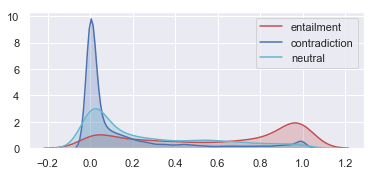

In [512]:
import seaborn as sns

sns.set(rc={'figure.figsize':(6,2.5)})
           
# plot of 2 variables
p1=sns.kdeplot(df['entailment'], shade=True, color="r")
p1=sns.kdeplot(df['contradiction'], shade=True, color="b")
p1=sns.kdeplot(df['neutral'], shade=True, color="c")



In [508]:
df2 = pd.DataFrame({'Embed Vector Similarity' : dsimilarity_score, 'Entities Similarity': dentity_similarity_score, 'Nouns Similarity':dnoun_similarity_score} )

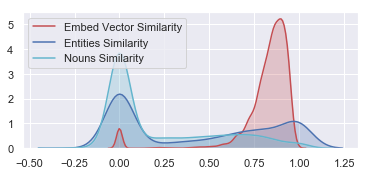

In [511]:
sns.set(rc={'figure.figsize':(6,2.5)})
           
# plot of 2 variables
p1=sns.kdeplot(df2['Embed Vector Similarity'], shade=True, color="r")
p1=sns.kdeplot(df2['Entities Similarity'], shade=True, color="b")
p1=sns.kdeplot(df2['Nouns Similarity'], shade=True, color="c")


In [513]:
dlabel_textual_entailment2 = []
for i in range(len(dconta_score)):
    if dconta_score[i] > 0.98 and dent_score[i] < 0.1 and dnut_core[i] < 0.1:
        dlabel_textual_entailment2.append('SUPPORTS')
    elif dconta_score[i] < 0.25 and dent_score[i] >= 0.5 and dnut_core[i] < 0.25:
        dlabel_textual_entailment2.append('REFUTES')
    else:
        dlabel_textual_entailment2.append('NOT ENOUGH INFO')

In [548]:
Counter(dlabel)

Counter({'NOT ENOUGH INFO': 3117, 'REFUTES': 886, 'SUPPORTS': 998})

In [514]:
Counter(dlabel_textual_entailment2)

Counter({'SUPPORTS': 995, 'NOT ENOUGH INFO': 3595, 'REFUTES': 411})

In [515]:
dNEI_NEI2 = 0
dSPT_NEI2 = 0
dRFT_NEI2 = 0
dNEI_SPT2 = 0
dNEI_RFT2 = 0
dSPT_SPT2 = 0
dRFT_RFT2 = 0
dSPT_RFT2 = 0
dRFT_SPT2 = 0
dcombine_prediction2 = []
for i in range(len(dlabel_textual_entailment2)):
    if dlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        dNEI_NEI2 += 1
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        dSPT_NEI2 += 1
        dcombine_prediction2.append(dlabel[i])
    elif dlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        dRFT_NEI2 += 1    
        dcombine_prediction2.append(dlabel[i])
    elif dlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        dNEI_SPT2 += 1
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'REFUTES':
        dNEI_RFT2 += 1
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        dSPT_SPT2 += 1   
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'REFUTES':
        dRFT_RFT2 += 1      
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'REFUTES':
        dSPT_RFT2 += 1   
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        dRFT_SPT2 += 1 
        dcombine_prediction2.append(dlabel[i])

In [516]:
Counter(dcombine_prediction2)

Counter({'SUPPORTS': 1639, 'NOT ENOUGH INFO': 2138, 'REFUTES': 1224})

In [517]:
print("Same NEI:",dNEI_NEI2)
print("Support - NEI:",dSPT_NEI2)
print("Refute - NEI:",dRFT_NEI2)
print("NEI - Support:", dNEI_SPT2)
print("NEI - Refute:", dNEI_RFT2)
print("Same Support:",dSPT_SPT2)
print("Same Refute:",dRFT_RFT2)
print("Support - Refute:",dSPT_RFT2)
print("Refute - Support:",dRFT_SPT2)

Same NEI: 2138
Support - NEI: 773
Refute - NEI: 684
NEI - Support: 689
NEI - Refute: 290
Same Support: 177
Same Refute: 73
Support - Refute: 48
Refute - Support: 129


In [518]:
print("### GET ACTUAL DEVELOPMENT DATA ###")

adev_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "devset.json")
with open(adev_path) as json_file:  
    adevelopment = json.load(json_file)
    
adrowid = list(adevelopment.keys())
adclaim = []
adlabel = []
adevidence = []
for idx in adrowid:
    adclaim.append(adevelopment[idx]['claim'])
    adlabel.append(adevelopment[idx]['label'])
    adevidence.append(adevelopment[idx]['evidence'])

### GET ACTUAL DEVELOPMENT DATA ###


In [519]:
adNEI_NEI2 = 0
adSPT_NEI2 = 0
adRFT_NEI2 = 0
adNEI_SPT2 = 0
adNEI_RFT2 = 0
adSPT_SPT2 = 0
adRFT_RFT2 = 0
adSPT_RFT2 = 0
adRFT_SPT2 = 0
adcombine_prediction2 = []
for i in range(len(dlabel_textual_entailment2)):
    if adlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        adNEI_NEI2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        adSPT_NEI2 += 1
    elif adlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        adRFT_NEI2 += 1    
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        adNEI_SPT2 += 1
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'REFUTES':
        adNEI_RFT2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        adSPT_SPT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'REFUTES':
        adRFT_RFT2 += 1      
    elif adlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'REFUTES':
        adSPT_RFT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        adRFT_SPT2 += 1 

In [520]:
print("Same NEI:",adNEI_NEI2)
print("Support - NEI:",adSPT_NEI2)
print("Refute - NEI:",adRFT_NEI2)
print("NEI - Support:", adNEI_SPT2)
print("NEI - Refute:", adNEI_RFT2)
print("Same Support:",adSPT_SPT2)
print("Same Refute:",adRFT_RFT2)
print("Support - Refute:",adSPT_RFT2)
print("Refute - Support:",adRFT_SPT2)

Same NEI: 1260
Support - NEI: 1207
Refute - NEI: 1128
NEI - Support: 303
NEI - Refute: 104
Same Support: 411
Same Refute: 258
Support - Refute: 49
Refute - Support: 281


In [521]:
cadNEI_NEI2 = 0
cadSPT_NEI2 = 0
cadRFT_NEI2 = 0
cadNEI_SPT2 = 0
cadNEI_RFT2 = 0
cadSPT_SPT2 = 0
cadRFT_RFT2 = 0
cadSPT_RFT2 = 0
cadRFT_SPT2 = 0
cadcombine_prediction2 = []
for i in range(len(dcombine_prediction2)):
    if adlabel[i] == 'NOT ENOUGH INFO' and dcombine_prediction2[i] == 'NOT ENOUGH INFO':
        cadNEI_NEI2 += 1
    elif adlabel[i] == 'SUPPORTS' and dcombine_prediction2[i] == 'NOT ENOUGH INFO':
        cadSPT_NEI2 += 1
    elif adlabel[i] == 'REFUTES' and dcombine_prediction2[i] == 'NOT ENOUGH INFO':
        cadRFT_NEI2 += 1    
    elif adlabel[i] == 'NOT ENOUGH INFO' and dcombine_prediction2[i] == 'SUPPORTS':
        cadNEI_SPT2 += 1
    elif adlabel[i] == 'NOT ENOUGH INFO' and dcombine_prediction2[i] == 'REFUTES':
        cadNEI_RFT2 += 1
    elif adlabel[i] == 'SUPPORTS' and dcombine_prediction2[i] == 'SUPPORTS':
        cadSPT_SPT2 += 1   
    elif adlabel[i] == 'REFUTES' and dcombine_prediction2[i] == 'REFUTES':
        cadRFT_RFT2 += 1      
    elif adlabel[i] == 'SUPPORTS' and dcombine_prediction2[i] == 'REFUTES':
        cadSPT_RFT2 += 1   
    elif adlabel[i] == 'REFUTES' and dcombine_prediction2[i] == 'SUPPORTS':
        cadRFT_SPT2 += 1 

In [522]:
print("Same NEI:",cadNEI_NEI2)
print("Support - NEI:",cadSPT_NEI2)
print("Refute - NEI:",cadRFT_NEI2)
print("NEI - Support:", cadNEI_SPT2)
print("NEI - Refute:", cadNEI_RFT2)
print("Same Support:",cadSPT_SPT2)
print("Same Refute:",cadRFT_RFT2)
print("Support - Refute:",cadSPT_RFT2)
print("Refute - Support:",cadRFT_SPT2)

Same NEI: 767
Support - NEI: 702
Refute - NEI: 669
NEI - Support: 536
NEI - Refute: 364
Same Support: 683
Same Refute: 578
Support - Refute: 282
Refute - Support: 420


In [523]:
tadNEI_NEI2 = 0
tadSPT_NEI2 = 0
tadRFT_NEI2 = 0
tadNEI_SPT2 = 0
tadNEI_RFT2 = 0
tadSPT_SPT2 = 0
tadRFT_RFT2 = 0
tadSPT_RFT2 = 0
tadRFT_SPT2 = 0
tadcombine_prediction2 = []
for i in range(len(dcombine_prediction2)):
    if adlabel[i] == 'NOT ENOUGH INFO' and dlabel[i] == 'NOT ENOUGH INFO':
        tadNEI_NEI2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel[i] == 'NOT ENOUGH INFO':
        tadSPT_NEI2 += 1
    elif adlabel[i] == 'REFUTES' and dlabel[i] == 'NOT ENOUGH INFO':
        tadRFT_NEI2 += 1    
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel[i] == 'SUPPORTS':
        tadNEI_SPT2 += 1
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel[i] == 'REFUTES':
        tadNEI_RFT2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel[i] == 'SUPPORTS':
        tadSPT_SPT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel[i] == 'REFUTES':
        tadRFT_RFT2 += 1      
    elif adlabel[i] == 'SUPPORTS' and dlabel[i] == 'REFUTES':
        tadSPT_RFT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel[i] == 'SUPPORTS':
        tadRFT_SPT2 += 1 

In [524]:
print("Same NEI:",tadNEI_NEI2)
print("Support - NEI:",tadSPT_NEI2)
print("Refute - NEI:",tadRFT_NEI2)
print("NEI - Support:", tadNEI_SPT2)
print("NEI - Refute:", tadNEI_RFT2)
print("Same Support:",tadSPT_SPT2)
print("Same Refute:",tadRFT_RFT2)
print("Support - Refute:",tadSPT_RFT2)
print("Refute - Support:",tadRFT_SPT2)

Same NEI: 1055
Support - NEI: 1019
Refute - NEI: 1043
NEI - Support: 339
NEI - Refute: 273
Same Support: 407
Same Refute: 372
Support - Refute: 241
Refute - Support: 252


In [529]:
print(accuracy_score(adlabel,dcombine_prediction2))

0.4055188962207559


In [530]:
print(classification_report(adlabel,dcombine_prediction2))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.36      0.46      0.40      1667
        REFUTES       0.47      0.35      0.40      1667
       SUPPORTS       0.42      0.41      0.41      1667

       accuracy                           0.41      5001
      macro avg       0.42      0.41      0.41      5001
   weighted avg       0.42      0.41      0.41      5001



In [531]:
print(accuracy_score(adlabel,dlabel))

0.3667266546690662


In [532]:
print(classification_report(adlabel,dlabel))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.34      0.63      0.44      1667
        REFUTES       0.42      0.22      0.29      1667
       SUPPORTS       0.41      0.24      0.31      1667

       accuracy                           0.37      5001
      macro avg       0.39      0.37      0.35      5001
   weighted avg       0.39      0.37      0.35      5001



In [ ]:
dfeatures = defaultdict(Counter)
dclaim_embed = dict()
devidences_embed = dict()
dconta_score = dict()
dent_score = dict()
dnut_core  = dict()
dsimilarity_score = dict()
dentity_similarity_score = dict()
dnoun_similarity_score = dict()

In [534]:

dev_claim_embed = []
dev_evidences_embed = []

for i in range(len(dsimilarity_score)):
        dev_claim_embed.append(dclaim_embed[i])
        dev_evidences_embed.append(devidences_embed[i])
        
dev_claim_embed_array = np.array(dev_claim_embed)
dev_evidences_embed_array = np.array(dev_evidences_embed)


In [540]:
dev_entity_similarity_score = []
dev_noun_similarity_score = []
dev_similarity_score = []

for i in range(len(dsimilarity_score)):
        dev_entity_similarity_score.append(dentity_similarity_score[i]) 
        dev_noun_similarity_score.append(dnoun_similarity_score[i])
        dev_similarity_score.append(dsimilarity_score[i])   
      

In [541]:
dev_entity_similarity_score_array = np.array(dev_entity_similarity_score)
dev_entity_similarity_score_array.resize((len(dev_entity_similarity_score_array), 1))
dev_noun_similarity_score_array = np.array(dev_noun_similarity_score)
dev_noun_similarity_score_array.resize((len(dev_noun_similarity_score_array), 1))
dev_similarity_score_array = np.array(dev_similarity_score)
dev_similarity_score_array.resize((len(dev_similarity_score_array), 1))


In [542]:
dev_feature_combine = np.concatenate((dev_claim_embed_array,dev_evidences_embed_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_entity_similarity_score_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_noun_similarity_score_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_similarity_score_array), axis=1)

In [543]:
predictions_dev = MLPClassifier_300_undersampling.predict(dev_feature_combine)
accuracy_dev = accuracy_score(adlabel,predictions_dev)
results_dev = classification_report(adlabel,predictions_dev,  output_dict=True)

print(accuracy_dev)
print(results_dev)

0.4401119776044791
{'NOT ENOUGH INFO': {'precision': 0.44036697247706424, 'recall': 0.057588482303539294, 'f1-score': 0.10185676392572944, 'support': 1667}, 'REFUTES': {'precision': 0.4365761430044689, 'recall': 0.7618476304739052, 'f1-score': 0.55506993006993, 'support': 1667}, 'SUPPORTS': {'precision': 0.4455709711846318, 'recall': 0.5008998200359928, 'f1-score': 0.4716181869528382, 'support': 1667}, 'accuracy': 0.4401119776044791, 'macro avg': {'precision': 0.44083802888872164, 'recall': 0.44011197760447907, 'f1-score': 0.3761816269828325, 'support': 5001}, 'weighted avg': {'precision': 0.4408380288887216, 'recall': 0.4401119776044791, 'f1-score': 0.37618162698283253, 'support': 5001}}


In [544]:
Counter(predictions_dev)

Counter({'REFUTES': 2909, 'SUPPORTS': 1874, 'NOT ENOUGH INFO': 218})

In [547]:
results_dev = classification_report(adlabel,predictions_dev)
print(results_dev)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.44      0.06      0.10      1667
        REFUTES       0.44      0.76      0.56      1667
       SUPPORTS       0.45      0.50      0.47      1667

       accuracy                           0.44      5001
      macro avg       0.44      0.44      0.38      5001
   weighted avg       0.44      0.44      0.38      5001

